<a href="https://colab.research.google.com/github/manideep1428/Image_classifiacation/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from pathlib import Path
from PIL import Image
import random

In [5]:
!pip install torchinfo
from torchinfo import summary

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Model is using {device}')

Model is using cuda


##Download the DataCustom DataSet

In [7]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

#If data don't exist
if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  with open (data_path/"pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  #Unzip the file
  with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [8]:

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
train_dir = image_path / "train"
test_dir = image_path / "test"

## Define transforms

In [9]:
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

## Load datasets and

##Create DataLoaders

In [10]:
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

## Define model


In [11]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
       return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [12]:
torch.manual_seed(42)
model = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data.classes)).to(device)

# Display model summary
summary(model, input_size=(1, 3, 64, 64))


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

##Define training and testing functions


In [13]:
def train_step(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    return train_loss / len(dataloader), train_acc / len(dataloader)


def test_step(model, dataloader, loss_fn):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)
    return test_loss / len(dataloader), test_acc / len(dataloader)


##Define training loop

In [14]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn)
        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

## Set up loss function and optimizer


In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Train the model


In [16]:

epochs = 15
results = train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs)


Epoch: 1 | train_loss: 1.1230 | train_acc: 0.2930 | test_loss: 1.1215 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1065 | train_acc: 0.3047 | test_loss: 1.1190 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.0984 | train_acc: 0.2930 | test_loss: 1.1290 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.1120 | train_acc: 0.2969 | test_loss: 1.1270 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.1015 | train_acc: 0.3047 | test_loss: 1.0975 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.0914 | train_acc: 0.4062 | test_loss: 1.0710 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.1137 | train_acc: 0.2812 | test_loss: 1.0620 | test_acc: 0.5417
Epoch: 8 | train_loss: 1.0962 | train_acc: 0.4023 | test_loss: 1.0811 | test_acc: 0.5417
Epoch: 9 | train_loss: 1.1019 | train_acc: 0.2812 | test_loss: 1.0833 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.0967 | train_acc: 0.2812 | test_loss: 1.0932 | test_acc: 0.2083
Epoch: 11 | train_loss: 1.0925 | train_acc: 0.4141 | test_loss: 1.1066 | test_acc: 0.1979
Epoch: 12 | train_l

## Plot results


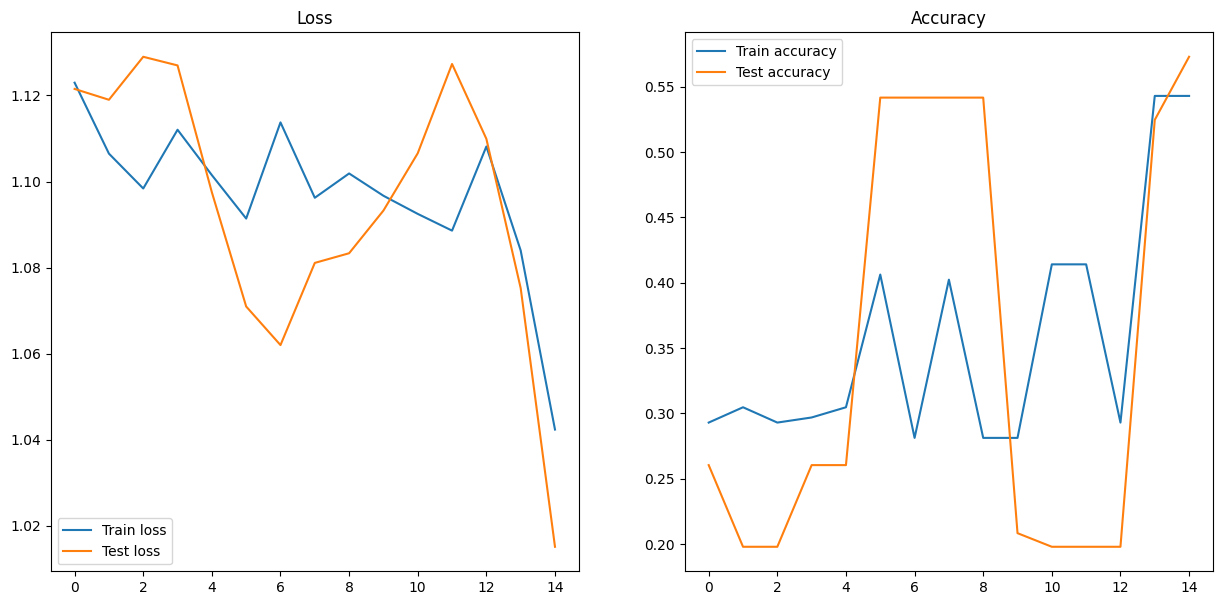

In [17]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='Train loss')
plt.plot(results['test_loss'], label='Test loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results['train_acc'], label='Train accuracy')
plt.plot(results['test_acc'], label='Test accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [39]:
def test_custom(model, dataloader):
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            test_pred_labels = test_pred_logits.argmax(dim=1)
            return test_pred_labels

In [21]:
# Download custom image
import requests
from pathlib import Path

data_path  = Path("data/")
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data/04-pizza-dad.jpeg already exists, skipping download.


Your Image is Looking like "" steak "" 


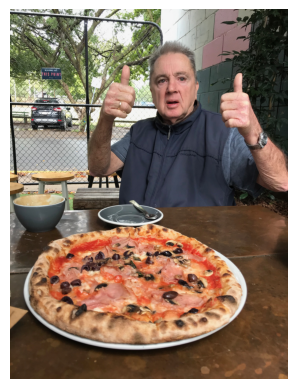

In [56]:
import torchvision

# Read in custom image
custom_image_to_test = torchvision.io.read_image(str(custom_image_path))/255


plt.imshow(custom_image_to_test.permute(1, 2, 0))
plt.axis(False)

# Preprocessing the image
custom_image_to_test = custom_image_to_test.unsqueeze(0)

data_transform_to_test = transforms.Compose([
    transforms.Resize((64, 64)),
])


custom_image_main =  data_transform_to_test(custom_image_to_test)

#Predicting
custom_image_main = custom_image_main.to(device)
model.eval()
with torch.inference_mode():
    custom_image_pred = model(custom_image_main)
    result = train_data.classes[custom_image_pred.argmax()]
    print(f'Your Image is Looking like "" {result} "" ')



## this model build on 25 August , I have to train much to increase accuracy

This is My GITHUB  :  https://github.com/manideep1428/

contact : saimanideep.ch12345@gmail.com
###or
Here many ways to contant me : https://portfolio-rho-self-26.vercel.app/
